# 2.0 - Data Preparation

_by Michael Joshua Vargas_

This notebook performs data loading, initial data inspection, missing value treatment, duplicate checking, data dictionary generation, and data filtering for early fraud detection.

## Data Inspection and Setup


In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy import stats
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

import os

import sys
from pathlib import Path

import warnings

warnings.filterwarnings('ignore')


### Load the dataset

In [3]:
# Get the current working directory of the notebook
notebook_dir = Path(os.getcwd())

# Navigate up one level to reach the project root directory
project_root = notebook_dir.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import from config.py
from bank_fraud.config import INTERIM_EDA_DATASET, DATA_DICTIONARIES_DIR, REPORTS_FIGURES_DIR

df = pd.read_parquet(INTERIM_EDA_DATASET).copy()

print(f"""
The dataset has a total of {df.shape[0]} rows and a total of {df.shape[1]} columns.
""")


The dataset has a total of 1073778 rows and a total of 154 columns.



### Data Types
 - Check the data type of each column. Are dates stored as objects? Are numbers stored as strings?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073778 entries, 0 to 1073777
Columns: 154 entries, profile_id to destination_entropy_out
dtypes: datetime64[ns](11), float64(102), int64(4), object(37)
memory usage: 1.2+ GB


The `df.info()` can be slow or memory-intensive for very large datasets as it tries to compute non-null counts for all columns. Let us use alternative and more efficient ways to check data types and identify missing values with their counts:

In [5]:
# Get all the columns and their data types
pd.set_option('display.max_rows', None)

print("Column Data Types: ")
print(df.dtypes)

# Get all the columns and their data types
pd.reset_option('display.max_rows')

Column Data Types: 
profile_id                                                         object
account_no                                                         object
full_name                                                          object
username                                                           object
date_of_birth                                              datetime64[ns]
gr_card_no                                                         object
cellphone                                                          object
orig_onboarded_datetime                                    datetime64[ns]
orig_onboarded_date                                        datetime64[ns]
orig_channel                                                       object
orig_os                                                            object
origination_type                                                   object
origination_sub_type                                               object
carded_status     

Upon inspecting the data types, it's noted that specific columns (e.g., `profile_id`, `account_no`, `full_name`, `username`,`gr_card_no`, `cellphone`, `account_number`, `source_account_number`, and `destination_account_number`) are currently object type. It's important to clarify that these columns originally contained int64 numerical data. However, prior to ingestion, a cryptographic hashing function was applied to these fields for privacy preservation, converting their integer values into non-numeric, string-like representations, hence their current object data type.


### Missing Values and Their Counts/Percentages


In [6]:
# Get all the columns and their data types
pd.set_option('display.max_rows', None)

# Calculate the count of missing values for each column
missing_counts = df.isnull().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Create a DataFrame to display the results clearly
missing_info = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentages': missing_percentages
})

# Filter to show only columns that have missing values
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)

print("Columns with Missing Values:")
if not missing_info.empty:
    print(missing_info)
else:
    print("No missing values found in any column.")

# Reset
pd.reset_option('display.max_rows')

Columns with Missing Values:
                                                    Missing Count  \
max_amount_PESONET_OUT                                    1073777   
min_amount_PESONET_OUT                                    1073777   
count_PESONET_OUT                                         1073777   
amount_PESONET_OUT                                        1073777   
min_amount_PESONET_IN                                     1065201   
count_PESONET_IN                                          1065201   
amount_PESONET_IN                                         1065201   
max_amount_PESONET_IN                                     1065201   
first_mob_num_date                                        1055319   
txn_velocity_accel_wk4                                    1023238   
txn_velocity_accel_wk3                                    1021701   
first_fila_date                                           1019261   
first_fila_bank_code                                      1019261   
txn_a

**Initial Insights on Missing Data**

A significant portion of the dataset's columns exhibit a high percentage of missing values. This is not entirely unexpected in a real-world banking dataset and can be attributed to several factors:

   * **Progressive Feature Rollout:** Many of the features, especially those related to specific  transaction types (e.g., PESONET) or newer monitoring systems (e.g., kiosk_interaction), were likely introduced at different stages of the bank's operational history. As a result, historical data for these features is sparse or non-existent for older accounts or transactions.
   * **Conditional Data Generation:** Some features are only populated under specific conditions. For example, datetime_restricted and date_restricted are only relevant for accounts that have been restricted. Similarly, ops_comments are only present when an analyst has manually reviewed an account.
   * **Transactional Behavior:** The absence of transactional data (e.g., txn_count_week_wk1, txn_amt_week_wk1) for certain accounts is expected, as not all customers will transact within a given week.

**Implications for Modeling:**

The high percentage of missing data in many columns presents a challenge for our modeling efforts. We will need to carefully consider our feature selection and imputation strategies. A simple imputation approach, such as filling with the mean or median, may not be appropriate for all columns.


#### Treat the Missing and Nan Values


##### Numerical Variables


In [7]:
# Identify columns where NaN semantically means zero activity
# This list is derived from the missing value analysis and domain understanding.

zero_impute_cols = [
    'txn_count_week_wk1', 'txn_amt_week_wk1', 'txn_velocity_week_wk1', 'txn_days_active_week_wk1',
    'txn_count_week_wk2', 'txn_amt_week_wk2', 'txn_velocity_week_wk2', 'txn_days_active_week_wk2',
    'txn_count_week_wk3', 'txn_amt_week_wk3', 'txn_velocity_week_wk3', 'txn_days_active_week_wk3',
    'txn_count_week_wk4', 'txn_amt_week_wk4', 'txn_velocity_week_wk4', 'txn_days_active_week_wk4',
    'txn_velocity_delta_wk2_vs_wk1', 'txn_velocity_delta_wk3_vs_wk2', 'txn_velocity_delta_wk4_vs_wk3',
    'txn_velocity_accel_wk3', 'txn_velocity_accel_wk4',
    'txn_count_30d', 'txn_amt_30d', 'txn_velocity_30d', 'txn_days_active_30d',
    'txn_count_day_volatility_30d', 'txn_amt_day_volatility_30d',
    'txn_count_vol_score_wk1', 'txn_amt_vol_score_wk1',
    'txn_count_vol_score_wk2', 'txn_amt_vol_score_wk2',
    'txn_count_vol_score_wk3', 'txn_amt_vol_score_wk3',
    'txn_count_vol_score_wk4', 'txn_amt_vol_score_wk4',
    'max_txn_count_day', 'min_txn_count_day', 'max_txn_amt_day', 'min_txn_amt_day',
    'avg_amt_in_day', 'avg_amt_out_day', 'avg_net_flow_amt_day', 'avg_inflow_outflow_ratio_day',
    'num_same_day_cico_days', 'num_inflow_days', 'percent_inflow_same_day_out',
    'count_INSTAPAY_IN', 'count_INSTAPAY_OUT', 'count_PESONET_IN', 'count_PESONET_OUT',
    'count_total_in', 'count_total_out',
    'amount_INSTAPAY_IN', 'amount_INSTAPAY_OUT', 'amount_PESONET_IN', 'amount_PESONET_OUT',
    'total_amount_in', 'total_amount_out',
    'max_amount_INSTAPAY_IN', 'max_amount_INSTAPAY_OUT', 'max_amount_PESONET_IN', 'max_amount_PESONET_OUT',
    'min_amount_INSTAPAY_IN', 'min_amount_INSTAPAY_OUT', 'min_amount_PESONET_IN', 'min_amount_PESONET_OUT',
    'txn_days_active', 'weekend_txn_count', 'night_txn_count',
    'hour_entropy', 'weekday_entropy',
    'min_time_btwn_txns_sec', 'min_time_btwn_txns_days', 'max_time_btwn_txns_days', 'avg_time_btwn_txns_days',
    'cv_time_btwn_txns',
    'min_txn_sessions_per_day_3min', 'max_txn_sessions_per_day_3min',
    'min_txn_sessions_per_day_5min', 'max_txn_sessions_per_day_5min',
    'active_days_with_txns',
    'num_unique_source_accounts', 'num_unique_source_names',
    'num_unique_destination_accounts', 'num_unique_destination_names',
    'repeat_sources', 'total_sources', 'repeat_counterparty_ratio_in',
    'repeat_destinations', 'total_destinations', 'repeat_counterparty_ratio_out',
    'amt_from_source', 'amt_to_destination',
    'source_entropy_in', 'destination_entropy_out',
    'flag_txn_dropoff_after_wk1', 'rank', 'total_in', 'top_source_share_in',
    'rank.1', 'total_out', 'top_destination_share_out', 'source_entropy_in',
    'destination_entropy_out'
]

# Apply zero-imputation to the identified columns
for col in zero_impute_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

In [8]:
# Verify remaining missing values (should be only for columns where 0 imputation is not semantic)
print("Missing values after zero-imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after zero-imputation:
ticket_no                                                   974133
date_tagged                                                 976816
ops_comments                                                996532
datetime_restricted                                        1004374
date_restricted                                            1004374
athena_fraud_tag                                            974133
first_kiosk_interaction_organisation_site_name              299892
first_kiosk_interaction_organisation_presence_category      299892
first_kiosk_interaction_organisation_name                   299892
first_kiosk_interaction_kiosk_interaction_type              299880
latest_kiosk_interaction_organisation_site_name             299892
latest_kiosk_interaction_organisation_presence_category     299892
latest_kiosk_interaction_organisation_name                  299892
latest_kiosk_interaction_kiosk_interaction_type             299880
first_fila_date         

##### Categorical Variables


In [9]:
# Columns for which missingness means "no occurrence" and can be directly imputed with a descriptive string

direct_impute_categorical_cols = {
    'ticket_no': 'No Ticket',
    'ops_comments': 'No Comments',
    'athena_fraud_tag': 'No Athena Tag',
    'first_kiosk_interaction_organisation_site_name': 'No Kiosk Interaction',
    'first_kiosk_interaction_organisation_presence_category': 'No Kiosk Interaction',
    'first_kiosk_interaction_organisation_name': 'No Kiosk Interaction',
    'first_kiosk_interaction_kiosk_interaction_type': 'No Kiosk Interaction',
    'latest_kiosk_interaction_organisation_site_name': 'No Kiosk Interaction',
    'latest_kiosk_interaction_organisation_presence_category': 'No Kiosk Interaction',
    'latest_kiosk_interaction_organisation_name': 'No Kiosk Interaction',
    'latest_kiosk_interaction_kiosk_interaction_type': 'No Kiosk Interaction',
    'first_fila_bank_code': 'No FILA Interaction',
    'matching_level': 'No Matching Level'
}

for col, placeholder_str in direct_impute_categorical_cols.items():
    if col in df.columns:
        # Only fillna if there are actual NaNs to fill
        if df[col].isnull().any():
            df[col] = df[col].fillna(placeholder_str)
    else:
        print(f" - Warning: Column '{col}' not found in DataFrame. Skipping direct imputation.")

print("Missing values after direct categorical imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing values after direct categorical imputation:
date_tagged             976816
datetime_restricted    1004374
date_restricted        1004374
first_fila_date        1019261
first_mob_num_date     1055319
first_txn_date          645550
last_txn_date           645550
dtype: int64


For `datetime` features with missing values, we create an _is_missing indicator variable and leave the original `NaN`s. This approach is chosen because:
   * **No Meaningful "Zero"**: There's no logical "zero" equivalent for a missing date; arbitrary imputation can create artificial patterns.
   * **Algorithm Compatibility**: Modern tree-based models (e.g., XGBoost) can directly handle `NaN`s as a distinct category.
   * **Explicit Signal (Planned)**: The indicator variable, once created, will explicitly capture the predictive signal of missingness, allowing the model to learn from the absence of the date.


### Check for Duplicates


Checking for duplicate records is crucial for:
   1. **Data Accuracy**: Ensures each record is unique and valid, preventing skewed analyses.
   2. **Reliable Insights**: Avoids statistical bias and prevents machine learning models from overfitting to redundant data.
   3. **Efficiency**: Reduces unnecessary storage and processing, improving performance. 
   4. **Data Integrity**: Upholds business rules by ensuring unique identifiers are truly unique.

In [10]:
f"Our dataset has {df.duplicated().sum()} duplicates."

'Our dataset has 0 duplicates.'

### Descriptive Statistics


In [11]:
# Get all the columns and their description
pd.set_option('display.max_columns', None)

df.describe()

,date_of_birth,orig_onboarded_datetime,orig_onboarded_date,date_tagged,account_status_as_off,datetime_restricted,date_restricted,first_fila_date,change_email_occurence,change_email_flag,change_mob_num_occurence,change_mob_num_flag,first_mob_num_date,txn_count_week_wk1,txn_amt_week_wk1,txn_velocity_week_wk1,txn_days_active_week_wk1,txn_count_week_wk2,txn_amt_week_wk2,txn_velocity_week_wk2,txn_days_active_week_wk2,txn_count_week_wk3,txn_amt_week_wk3,txn_velocity_week_wk3,txn_days_active_week_wk3,txn_count_week_wk4,txn_amt_week_wk4,txn_velocity_week_wk4,txn_days_active_week_wk4,txn_velocity_delta_wk2_vs_wk1,txn_velocity_delta_wk3_vs_wk2,txn_velocity_delta_wk4_vs_wk3,txn_velocity_accel_wk3,txn_velocity_accel_wk4,flag_txn_dropoff_after_wk1,txn_count_30d,txn_amt_30d,txn_velocity_30d,txn_days_active_30d,txn_count_day_volatility_30d,txn_amt_day_volatility_30d,txn_count_vol_score_wk1,txn_amt_vol_score_wk1,txn_count_vol_score_wk2,txn_amt_vol_score_wk2,txn_count_vol_score_wk3,txn_amt_vol_score_wk3,txn_count_vol_score_wk4,txn_amt_vol_score_wk4,max_txn_count_day,min_txn_count_day,max_txn_amt_day,min_txn_amt_day,avg_amt_in_day,avg_amt_out_day,avg_net_flow_amt_day,avg_inflow_outflow_ratio_day,num_same_day_cico_days,num_inflow_days,percent_inflow_same_day_out,count_INSTAPAY_IN,count_INSTAPAY_OUT,count_PESONET_IN,count_PESONET_OUT,count_total_in,count_total_out,amount_INSTAPAY_IN,amount_INSTAPAY_OUT,amount_PESONET_IN,amount_PESONET_OUT,total_amount_in,total_amount_out,max_amount_INSTAPAY_IN,max_amount_INSTAPAY_OUT,max_amount_PESONET_IN,max_amount_PESONET_OUT,min_amount_INSTAPAY_IN,min_amount_INSTAPAY_OUT,min_amount_PESONET_IN,min_amount_PESONET_OUT,txn_days_active,first_txn_date,last_txn_date,weekend_txn_count,night_txn_count,hour_entropy,weekday_entropy,min_time_btwn_txns_sec,min_time_btwn_txns_days,max_time_btwn_txns_days,avg_time_btwn_txns_days,cv_time_btwn_txns,min_txn_sessions_per_day_3min,max_txn_sessions_per_day_3min,min_txn_sessions_per_day_5min,max_txn_sessions_per_day_5min,active_days_with_txns,num_unique_source_accounts,num_unique_source_names,num_unique_destination_accounts,num_unique_destination_names,repeat_sources,total_sources,repeat_counterparty_ratio_in,repeat_destinations,total_destinations,repeat_counterparty_ratio_out,amt_from_source,rank,total_in,top_source_share_in,amt_to_destination,rank.1,total_out,top_destination_share_out,source_entropy_in,destination_entropy_out
count,1073778,1073778,1073778,96962,1073778,69404,69404,54517,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,18459,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,428228,428228,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06,1.073778e+06
mean,1990-03-30 14:02:27.610400256,2025-03-05 12:29:35.365884672,2025-03-04 21:49:00.480434688,2025-03-23 04:22:48.759597056

### Data Dictionary Creation


**What You'll Find Here:**

Each entry in this dictionary provides a crucial piece of the puzzle, detailing not just the technical specifications of a feature, but also its business context and relevance to identifying fraudulent activities.

*   **`feature_name`**: The unique identifier for each data point.
*   **`data_type`**: The technical format of the data (e.g., `int64`, `float64`, `object`, `datetime64[ns]`), crucial for proper data handling and analysis.
*   **`description`**: A concise explanation of what the feature represents in a business context, highlighting its potential role in fraud detection. This is where the story of our data truly begins.
*   **`null_count`**: The number of missing values, indicating data completeness and potential areas for imputation or cleaning.
*   **`unique_count`**: The number of distinct values, offering insights into the variability and cardinality of the feature.

Beyond these core attributes, we provide additional, type-specific metadata to enrich our understanding:


--- 1. Adjust python Path to import from bank_fraud/ ---
add 'bank_fraud' directory to the Python path


In [12]:
# --- 1. Adjust python Path to import from bank_fraud/ ---
# add 'bank_fraud' directory to the Python path
bank_fraud_path = project_root / 'bank_fraud'

# Add bank_fraud to sys.path if it's not already there
if str(bank_fraud_path) not in sys.path:
    sys.path.insert(0, str(bank_fraud_path)) # Insert at the beginning for priority

# --- 2. Import the function ---
# Import from bank_fraud.utils.data_dictionary_generator
from bank_fraud.utils.data_dictionary_generator import run_data_dictionary_pipeline

exported_path = run_data_dictionary_pipeline(df, output_dir_name="references")
print(f"\nData dictionaries generated and exported to: {exported_path.relative_to(project_root)}")


Data dictionaries generated and exported to: references


#### Numeric Features: Quantifying Behavior


For numerical features (e.g., transaction amounts, frequencies, durations), we delve into their statistical distribution. These metrics help us understand typical behaviors, identify outliers, and quantify the scale of various activities.

*   **`count`**: The number of non-null observations.
*   **`mean`**: The average value, indicating central tendency.
*   **`std`**: The standard deviation, measuring the dispersion or spread of data.
*   **`min` / `max`**: The minimum and maximum values, defining the range of the data.
*   **`25%` / `50%` (Median) / `75%`**: Quartiles that provide insights into the distribution and potential skewness of the data.

In [13]:
from bank_fraud.config import DATA_DICTIONARIES_DIR

pd.set_option('display.max_rows', None)

# bank-fraud-detection-project\references\numeric_data_dictionary.csv
num_path = DATA_DICTIONARIES_DIR / 'numeric_data_dictionary.csv'
num_df = pd.read_csv(num_path)

num_df

,feature_name,data_type,description,null_count,unique_count,count,mean,std,min,25%,50%,75%,max
0,change_email_occurence,int64,Contact information change frequency indicatin...,0,11,1073778.0,1.229304e-02,0.135366,0.000000,0.0,0.0,0.000000,2.100000e+01
1,change_mob_num_occurence,int64,Contact information change frequency indicatin...,0,13,1073778.0,1.902535e-02,0.181945,0.000000,0.0,0.0,0.000000,9.300000e+01
2,txn_count_week_wk1,float64,Weekly transaction count for wk1 showing accou...,0,469,1073778.0,9.649974e-01,10.235708,0.000000,0.0,0.0,1.000000,7.060000e+02
3,txn_amt_week_wk1,float64,Weekly transaction amount for wk1 indicating s...,0,30873,1073778.0,3.277361e+03,37569.537879,0.000000,0.0,0.0,85.000000,1.605500e+07
4,txn_velocity_week_wk1,float64,Transaction velocity (transactions per day) fo...,0,469,1073778.0,1.378568e-01,1.462244,0.000000,0.0,0.0,0.142857,1.008571e+02
5,txn_days_active_week_wk1,float64,Number of active transaction days in wk1 showi...,0,8,1073778.0,4.215611e-01,0.856192,0.000000,0.0,0.0,1.000000,7.000000e+00
6,txn_count_week_wk2,float64,Weekly transaction count for wk2 showing accou...,0,529,1073778.0,8.212601e-01,11.852403,0.000000,0.0,0.0,0.000000,9.360000e+02
7,txn_amt_week_wk2,float64,Weekly transaction amount for wk2 indicating s...,0,27491,1073778.0,2.719325e+03,39038.898953,0.000000,0.0,0.0,0.000000,1.924500e+07
8,txn_velocity_week_wk2,float64,Transaction velocity (transactions per day) fo...,0,529,1073778.0,1.173229e-01,1.693200,0.000000,0.0,0.0,0.000000,1.337143e+02
9,txn_days_active_week_wk2,float64,Number of active transaction days in wk2 showi...,0,8,1073778.0,2.476592e-01,0.765691,0.000000,0.0,0.0,0.000000,7.000000e+00


#### Categorical Features: Classifying Patterns


Categorical features (e.g., transaction types, channels, flags) help us segment our data and uncover distinct patterns. For these, we focus on understanding their diversity and common occurrences.

*   **`other_categories_count`**: The count of less frequent categories, indicating the long tail of unique values.
*   **`min_value` / `max_value`**: For numerical-like categorical data (e.g., encoded categories), these show the range.
*   **`date_range_days`**: For date-time related categorical features, the span in days.
*   **`value_range`**: For numerical-like categorical data, the difference between max and min.

In [14]:
categorical_path = DATA_DICTIONARIES_DIR / 'categorical_data_dictionary.csv'
categorical_df = pd.read_csv(categorical_path)

categorical_df

,feature_name,data_type,description,null_count,unique_count,min_value,max_value,date_range_days,other_categories_count,value_range
0,date_of_birth,datetime64[ns],Customer birth date for age-based risk profili...,0,22796,1925-01-25 00:00:00,2007-05-12 00:00:00,30057.0,NaN,NaN
1,orig_onboarded_datetime,datetime64[ns],Account opening timestamp for tenure analysis ...,0,1071543,2025-01-01 00:07:34.340000,2025-05-12 23:59:49.056000,131.0,NaN,NaN
2,orig_onboarded_date,datetime64[ns],Account opening timestamp for tenure analysis ...,0,132,2025-01-01 00:00:00,2025-05-12 00:00:00,131.0,NaN,NaN
3,orig_channel,object,Account opening channel (online/branch) indica...,0,3,NaN,NaN,NaN,0.0,NaN
4,orig_os,object,Operating system used during account opening i...,0,3,NaN,NaN,NaN,0.0,NaN
5,origination_type,object,Type of account origination process indicating...,0,3,NaN,NaN,NaN,0.0,NaN
6,origination_sub_type,object,Categorical information for origination sub ty...,0,6,NaN,NaN,NaN,0.0,NaN
7,carded_status,object,Debit/credit card information indicating payme...,0,2,NaN,NaN,NaN,0.0,NaN
8,card_type,object,Debit/credit card information indicating payme...,0,2,NaN,NaN,NaN,0.0,NaN
9,orig_primary_source_of_funds,object,Declared primary income source for AML complia...,0,10,NaN,NaN,NaN,0.0,NaN


#### Identifier Features: Tracking Entities


Identifier features (e.g., account numbers, profile IDs) are critical for linking information across the dataset and ensuring data integrity. They are the backbone for tracking individual entities and their activities.

*   **`total_count`**: The total number of records in the dataset.
*   **`uniqueness_ratio`**: The proportion of unique values, indicating how well a feature serves as an identifier.
*   **`duplicate_count`**: The number of duplicate entries, highlighting potential data quality issues or expected repetitions.
*   **`is_primary_key`**: A boolean flag indicating if the feature can serve as a unique identifier for each record (no duplicates, no nulls).

In [15]:
# bank-fraud-detection-project\references\identifier_data_dictionary.csv

identifier_path = DATA_DICTIONARIES_DIR / 'identifier_data_dictionary.csv'
identifier_df = pd.read_csv(identifier_path)

identifier_df

,feature_name,data_type,description,null_count,unique_count,total_count,uniqueness_ratio,duplicate_count,is_primary_key
0,profile_id,object,Unique customer identifier for linking account...,0,1073778,1073778,1.000000,0,True
1,account_no,object,Primary account number for transaction trackin...,0,1073778,1073778,1.000000,0,True
2,full_name,object,Customer full name for identity verification a...,0,1073390,1073778,0.999639,388,False
3,username,object,Digital platform username indicating online ba...,0,1073778,1073778,1.000000,0,True
4,gr_card_no,object,Debit/credit card information indicating payme...,0,1073162,1073778,0.999426,616,False
5,cellphone,object,Registered mobile number for customer contact ...,0,1073778,1073778,1.000000,0,True
6,account_number,object,Categorical information for account number sup...,0,428229,1073778,0.398806,645549,False
7,source_account_number,object,Categorical information for source account num...,0,264096,1073778,0.245950,809682,False
8,destination_account_number,object,Categorical information for destination accoun...,0,221439,1073778,0.206224,852339,False


**Identifier Data Types: Hashing for Privacy**

Some identifier columns, like `profile_id` or `account_no`, `gr_card_no`, `cellphone`, `account_number`, `source_account_number`, and `destination_account_number` appear as `object` (string) types instead of integers. This is because they have been **hashed** to protect sensitive customer identities. Hashing anonymizes the data while still allowing these columns to serve as unique identifiers for analytical purposes.


### Data Preparation: Filtering for Early Fraud Detection and other types of filtering


This section performs several crucial filtering steps to prepare the dataset
for early fraud detection modeling:

1. **Survival Days Filtering**:
    *   Removes CONFIRMED_FRAUD accounts with survival_days <= 7.
    *   Removes NON_FRAUD accounts with survival_days > 60.
2. **Onboarding Cutoff Date Filtering**: Removes accounts onboarded after 2025-05-11.
3. **KYC_HOLD Exclusion**: Removes accounts with 'dna_final_tag' == 'KYC_HOLD'.
4. **Redundant Column Dropping**: Removes 'account_number', 'orig_onboarded_date', 'date_restricted', 'repeat_sources', 'repeat_destinations', 'min_time_btwn_txns_days',  'total_destinations', 'rank.1', and 'min_time_btwn_txns_sec'.


This step is crucial for aligning our data with the model's objective: **predicting early fraud (accounts restricted between 7 and 60 days).**

   1. **Calculate `survival_days`**: We compute the duration (in days) from `orig_onboarded_datetime` to `date_restricted`.
   2. **Filter and Categorize Data**: The DataFrame is then filtered and categorized into meaningful "survival day buckets" based on `survival_days`.
       * **Target Bucket (7-60 days)**: This is our primary focus for "early detection."      
       * **Why 0-7 days are excluded**: Accounts with very short survival periods (0-7 days) often exhibit minimal or no transaction activity, limiting their value for behavior-based fraud modeling.
       * **Why >60 days are excluded(especially for non-fraud)**: For non-fraudulent accounts, including those with very long survival_days could bias the model, leading it to incorrectly associate longer account lifespans with inherent non-fraudulence. By focusing on the 7-60 day window, we ensure the model learns patterns relevant to early detection without this potential bias.
       
The following graph provides a frequency distribution of **2025 confirmed fraud accounts** across these critical survival day buckets, offering insights into the composition of our target population for analysis. This focused approach ensures our analysis is relevant and efficient, providing a strong foundation for feature importance (IV) and model development.: Accounts restricted after 60 days fall outside our definition of "early" detection.


In [16]:
# Define the cutoff date for calculating survival_days for non-restricted accounts
# This is the date the data was fetched.
CUTOFF_DATE = pd.to_datetime('2025-05-11')

# Calculate 'survival_days'
# For accounts with a date_restricted, use that date.
# For accounts without a date_restricted (NaN), use the CUTOFF_DATE.
df['survival_days'] = (df['date_restricted'].fillna(CUTOFF_DATE) - df['orig_onboarded_datetime']).dt.days

In [17]:
# Define the bins and labels for survival_days bucketing

bins = [-1, 1, 3, 7, 14, 21, 30, 60, 90, float('inf')]
labels = [
    'Same day (0-1 day)',
    'Very quick (1-3 days)',
    'Quick (3-7 days)',
    'Medium (7-14 days)',
    'Standard early (14-21 days)',
    'Standard late (22-30 days)',
    'Slow (30-60 days)',
    'Very slow (60-90 days)',
    'Extremely slow (>90 days)'
]

# Create the 'survival_days_bucket' column for ALL accounts
df.loc[:, 'survival_days_bucket'] = pd.cut(
    df['survival_days'],
    bins=bins,
    labels=labels,
    right=True,  # (a, b] interval
    include_lowest=True # Include -1 for 0 days
)

print("Calculated 'survival_days' and created 'survival_days_bucket' for all accounts.")

Calculated 'survival_days' and created 'survival_days_bucket' for all accounts.


Calculated 'survival_days' and created 'survival_days_bucket' for all accounts.


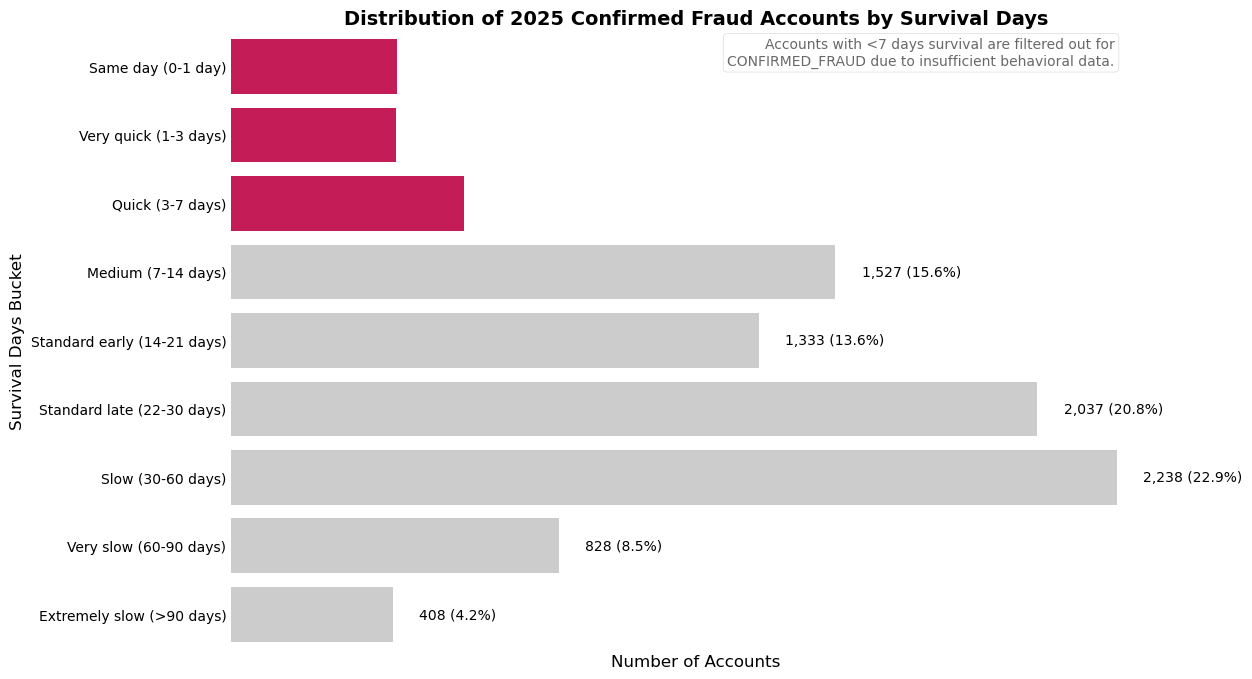

Plot saved to: reports\figures\2.0_survival_days_distribution.png

Numerical Distribution of 'survival_days_bucket' for CONFIRMED_FRAUD accounts:
survival_days_bucket
Same day (0-1 day)              419
Very quick (1-3 days)           416
Quick (3-7 days)                588
Medium (7-14 days)             1527
Standard early (14-21 days)    1333
Standard late (22-30 days)     2037
Slow (30-60 days)              2238
Very slow (60-90 days)          828
Extremely slow (>90 days)       408
Name: count, dtype: int64

Percentage Distribution of 'survival_days_bucket' for CONFIRMED_FRAUD accounts:
survival_days_bucket
Same day (0-1 day)              4.278129
Very quick (1-3 days)           4.247498
Quick (3-7 days)                6.003676
Medium (7-14 days)             15.591178
Standard early (14-21 days)    13.610374
Standard late (22-30 days)     20.798448
Slow (30-60 days)              22.850725
Very slow (60-90 days)          8.454156
Extremely slow (>90 days)       4.165816
Name: propor

In [18]:
# --- Data Preparation: Calculate Survival Days, Bucketing, and Unfiltered Visualization ---

# Define the custom color palette (for reference, not directly used as a seaborn palette name)
CUSTOM_PALETTE_RAW = ["#ffdd00", "#e0004e", "#01f0fb", "#4a0be8", "#ffffff", "#021820"]

# Define highlight and muted colors from the custom palette or standard grays
HIGHLIGHT_COLOR = "#e0004e" # A vibrant color from your palette, chosen for contrast
MUTED_COLOR = "#cccccc"    # A neutral light gray for de-emphasis

# Define the cutoff date for calculating survival_days for non-restricted accounts
# This is the date the data was fetched.
CUTOFF_DATE = pd.to_datetime('2025-05-11')

# Calculate 'survival_days' for ALL accounts
# For accounts with a date_restricted, use that date.
# For accounts without a date_restricted (NaN), use the CUTOFF_DATE.
df['survival_days'] = (df['datetime_restricted'].fillna(CUTOFF_DATE) - df['orig_onboarded_datetime']).dt.days

# Define the bins and labels for survival_days bucketing
bins = [-1, 1, 3, 7, 14, 21, 30, 60, 90, float('inf')]
labels = [
    'Same day (0-1 day)',
    'Very quick (1-3 days)',
    'Quick (3-7 days)',
    'Medium (7-14 days)',
    'Standard early (14-21 days)',
    'Standard late (22-30 days)',
    'Slow (30-60 days)',
    'Very slow (60-90 days)',
    'Extremely slow (>90 days)'
]

# Create the 'survival_days_bucket' column for ALL accounts
df.loc[:, 'survival_days_bucket'] = pd.cut(
    df['survival_days'],
    bins=bins,
    labels=labels,
    right=True,  # (a, b] interval
    include_lowest=True # Include -1 for 0 days
)

print("Calculated 'survival_days' and created 'survival_days_bucket' for all accounts.")

# --- Visualization of ALL Survival Days Buckets (Unfiltered, but only for CONFIRMED_FRAUD) ---

# Filter for CONFIRMED_FRAUD accounts for this specific visualization
df_fraud_viz = df[df['dna_final_tag'] == 'CONFIRMED_FRAUD'].copy()

# Ensure all labels are ordered correctly for the plot
all_ordered_labels = labels

# Define the target buckets for highlighting (Same day, Very quick, Quick)
target_highlight_buckets = [
    'Same day (0-1 day)',
    'Very quick (1-3 days)',
    'Quick (3-7 days)'
]

# Create a list of colors for the bar plot based on whether the bucket is a target bucket
plot_colors = []
for bucket_label in all_ordered_labels:
    if bucket_label in target_highlight_buckets:
        plot_colors.append(HIGHLIGHT_COLOR)
    else:
        plot_colors.append(MUTED_COLOR)

# Calculate counts and percentages for the filtered data (CONFIRMED_FRAUD)
# Use .reindex to ensure all target buckets are present, even if count is 0
bucket_counts_fraud = df_fraud_viz['survival_days_bucket'].value_counts().reindex(all_ordered_labels, fill_value=0)
bucket_percentages_fraud = (df_fraud_viz['survival_days_bucket'].value_counts(normalize=True) * 100).reindex(all_ordered_labels, fill_value=0)


plt.figure(figsize=(12, 8)) # Increased figure size for better spacing
ax = sns.barplot(x=bucket_counts_fraud.values, y=bucket_counts_fraud.index, palette=plot_colors) # Use the generated color list

# Add data labels (counts and percentages)
# Calculate a dynamic offset based on the maximum bar length to ensure text is outside
max_bar_length = bucket_counts_fraud.max()
text_offset = max_bar_length * 0.03 # 3% of the max bar length as offset

for i, (count, percentage) in enumerate(zip(bucket_counts_fraud.values, bucket_percentages_fraud.values)):
    # Determine text color based on bar color for contrast
    current_bar_color = plot_colors[i]
    text_color = 'white' if current_bar_color == HIGHLIGHT_COLOR else 'black'
    
    # Position text slightly to the right of the bar, ensuring it doesn't overlap
    ax.text(count + text_offset, i, # Position text after the bar
            f'{count:,} ({percentage:.1f}%)',
            va='center', ha='left', fontsize=10, color=text_color)

# Add a single annotation for the highlighted bars
# Position the annotation in the top right corner of the plot area
ax.text(ax.get_xlim()[1] * 0.95, # X-position: 95% of the way across the x-axis
        ax.get_ylim()[1] * 0.85, # Y-position: 85% of the way up the y-axis
        'Accounts with <7 days survival are filtered out for\nCONFIRMED_FRAUD due to insufficient behavioral data.',
        horizontalalignment='right',
        verticalalignment='top',
        fontsize=10, color='dimgray',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray', lw=0.5, alpha=0.8))


# Remove chart junk
sns.despine(left=True, bottom=True)

# Set title and labels with clear, concise language
plt.title('Distribution of 2025 Confirmed Fraud Accounts by Survival Days', fontsize=14, fontweight='bold')
plt.xlabel('Number of Accounts', fontsize=12)
plt.ylabel('Survival Days Bucket', fontsize=12)

# Improve x-axis tick formatting
ax.ticklabel_format(style='plain', axis='x')

# Remove y-axis ticks as labels are directly on bars
ax.tick_params(axis='y', length=0)
ax.set_xticks([])

plt.show()
# Save the plot
output_filename = REPORTS_FIGURES_DIR / '2.0_survival_days_distribution.png'
plt.savefig(output_filename, bbox_inches='tight')
print(f"Plot saved to: {output_filename.relative_to(project_root)}")
plt.close()

# For precise numerical values, still print the distributions
print("\nNumerical Distribution of 'survival_days_bucket' for CONFIRMED_FRAUD accounts:")
print(df_fraud_viz['survival_days_bucket'].value_counts(dropna=False).reindex(all_ordered_labels))
print("\nPercentage Distribution of 'survival_days_bucket' for CONFIRMED_FRAUD accounts:")
print((df_fraud_viz['survival_days_bucket'].value_counts(normalize=True) * 100).reindex(all_ordered_labels))

This step filters our dataset to align with the business definition of "early fraud detection" based on survival_days (onboarding to restriction/cutoff) and dna_final_tag.

* `CONFIRMED_FRAUD` Accounts: Retained if survival_days > 7. Accounts with 0-7 days are excluded due to insufficient behavioral data for modeling.
* `NON_FRAUD` Accounts: Retained if survival_days <= 60. Accounts surviving beyond 60 days are excluded to prevent model bias (where longer survival might incorrectly imply non-fraudulence).

This focused filtering ensures our model learns from the most relevant and unbiased population for early fraud detection.


In [19]:
initial_count = len(df)

# Define the filtering criteria for survival_days
min_survival_days_for_fraud = 7
max_survival_days_for_non_fraud = 60

# Initialize a boolean series for filtering
filter_condition = \
    ((df['dna_final_tag'] == 'CONFIRMED_FRAUD') & (df['survival_days'] > min_survival_days_for_fraud)) | \
    ((df['dna_final_tag'] == 'NON_FRAUD') & (df['survival_days'] <= max_survival_days_for_non_fraud))

# Apply the filter to the DataFrame
initial_row_count = len(df)
df = df[filter_condition].copy()

filtered_count = len(df)
print(f"survival_days Filtering: {initial_count} -> {filtered_count} rows ({initial_count - filtered_count} removed)")
print(f"After survival_days filtering: {df.shape}")


survival_days Filtering: 1073778 -> 505560 rows (568218 removed)
After survival_days filtering: (505560, 156)


This date (`2025-05-11`) represents the data extraction or 'as-of' date for the dataset. By filtering `orig_onboarded_datetime` against this cutoff, we ensure that our analysis only includes accounts that existed and were onboarded prior to or on the day the data snapshot was taken. This prevents any look-ahead bias and ensures consistency with the available data period.


In [20]:
initial_count = len(df)

# Ensure 'orig_onboarded_datetime' is datetime type
df['orig_onboarded_datetime'] = pd.to_datetime(df['orig_onboarded_datetime'])

# Date of data extraction
cutoff_date = pd.to_datetime('2025-05-11')

# Apply the filter
df = df[df['orig_onboarded_datetime'] <= cutoff_date].copy() # Use .copy() to prevent fragmentation

filtered_count = len(df)
print(f"Cutoff Date Filtering: {initial_count} -> {filtered_count} rows ({initial_count - filtered_count} removed)")
print(f"After Cutoff Date filtering: {df.shape}")

Cutoff Date Filtering: 505560 -> 493189 rows (12371 removed)
After Cutoff Date filtering: (493189, 156)


We remove 'KYC_HOLD' accounts because they represent profiles under review or with incomplete verification. These are not definitively classified as fraud or non-fraud, and including them would introduce ambiguity and noise into our target variable, hindering the model's ability to learn clear patterns for confirmed fraud detection.


In [21]:
initial_count = len(df)

# Exclude 'KYC_HOLD' and ensure only 'CONFIRMED_FRAUD' and 'NON_FRAUD' remain        
df = df[df['dna_final_tag'] != 'KYC_HOLD'].copy()
df = df[df['dna_final_tag'].isin(['CONFIRMED_FRAUD', 'NON_FRAUD'])].copy()

filtered_count = len(df)
print(f"KYC_HOLD Filtering: {initial_count} -> {filtered_count} rows ({initial_count - filtered_count} removed)")
print(f"After KYC_HOLD filtering: {df.shape}")

KYC_HOLD Filtering: 493189 -> 493189 rows (0 removed)
After KYC_HOLD filtering: (493189, 156)


**Dropping Redundant Columns**

This step streamlines our DataFrame by removing columns that are either redundant or whose information is now captured by newly engineered features.

   * `account_number`: Removed as other unique identifiers (profile_id, account_no) are     
     sufficient.
   * `orig_onboarded_date` & `date_restricted`: These date-only columns are removed because 
     their more granular timestamp counterparts, `orig_onboarded_datetime` and
     `datetime_restricted`, already exist and are used for precise temporal calculations like 
     `survival_days`. This avoids redundancy and ensures consistency in date/time handling.

  This reduces dimensionality, improves memory efficiency, and prevents potential multicollinearity, focusing our model on the most informative features.


In [22]:
# Define columns to drop
columns_to_drop = [
    'account_number', 
    'orig_onboarded_date', 
    'date_restricted',
    'repeat_sources',
    'repeat_destinations',
    'min_time_btwn_txns_days',
    'total_destinations',
    'min_time_btwn_txns_sec',
    'rank.1'
    ]

# Filter out columns that might not exist if previous steps removed them or they were never present
columns_to_drop_existing = [col for col in columns_to_drop if col in
      df.columns]

if columns_to_drop_existing:
    df = df.drop(columns=columns_to_drop_existing).copy() # Use .copy() to prevent fragmentation
    print(f"Dropped columns: {', '.join(columns_to_drop_existing)}")
else:
    print("No redundant columns found to drop from the predefined list.")

Dropped columns: account_number, orig_onboarded_date, date_restricted, repeat_sources, repeat_destinations, min_time_btwn_txns_days, total_destinations, min_time_btwn_txns_sec, rank.1


In [23]:
filtered_count = len(df)

print(f"Date filtering: {initial_count} -> {filtered_count} rows ({initial_count - filtered_count} removed)")
print(f"After date filtering: {df.shape}")

Date filtering: 493189 -> 493189 rows (0 removed)
After date filtering: (493189, 147)


## Save the prepared data for the next step


In [24]:
output_path = project_root / 'data' / 'interim' / '2.0_prepared_for_feature_selection.parquet'
df.to_parquet(output_path, index=False)
print(f"Prepared data saved to: {output_path.relative_to(project_root)}")

Prepared data saved to: data\interim\2.0_prepared_for_feature_selection.parquet
